This notebook examines the applicability of GRPs to predicting ETF prices

In [21]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import minimize, LinearConstraint

In [22]:
ETF_DATA_FILEPATH = "../data/raw/ETF_data.pkl"
ETF_METADATA_FILEPATH = "../data/raw/ETF_metadata.csv"
OUTPUT_FILE = "../data/results/monthly_portfolio_weights.csv"
NUM_DAYS_TIME_HORIZON = 365
ANALYSIS_COLUMN = "Adj Close"  # includes more info representative of the value. Not exactly the price.
NUM_DAYS_PREDICTION_PERIOD = 30

In [23]:
etf_data = pd.read_pickle(ETF_DATA_FILEPATH)
etf_data

XBI                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2016-06-27   51.320000   52.040001   49.509998   49.680000   49.282257   
2016-06-28   50.790001   52.139999   50.599998   52.000000   51.583679   
2016-06-29   53.230000   54.259998   52.830002   54.060001   53.627186   
2016-06-30   53.889999   54.480000   53.020000   54.080002   53.647030   
2016-07-01   53.830002   55.880001   53.799999   55.810001   55.363182   
...                ...         ...         ...         ...         ...   
2021-06-21  133.929993  135.279999  132.190002  134.789993  134.789993   
2021-06-22  134.630005  134.889999  131.889999  133.679993  133.679993   
2021-06-23  133.279999  135.059998  132.580002  134.309998  134.309998   
2021-06-24  135.210007  137.429993  135.119995  137.289993  137.289993   
2021-06-25  137.690002  138.779999  136.509995  138.679993  138.679993   

                            VIXY                                      ...  \
              Volume        Open        High         Low       Close  ...   
Date                                                                  ...   
2016-06-27  13702700  896.000000  947.200012  886.400024  890.400024  ...   
2016-06-28   6876700  857.599976  858.400024  798.400024  800.000000  ...   
2016-06-29   7892200  776.000000  776.799988  748.799988  757.599976  ...   
2016-06-30   7521400  747.200012  757.599976  728.799988  732.799988  ...   
2016-07-01   9345900  728.000000  731.200012  707.200012  711.200012  ...   
...              ...         ...         ...         ...         ...  ...   
2021-06-21   5111700   27.370001   28.200001   26.200001   26.500000  ...   
2021-06-22   4485000   26.799999   26.910000   25.240000   25.270000  ...   
2021-06-23   4142400   24.950001   25.020000   24.520000   24.770000  ...   
2021-06-24   5967900   24.150000   24.420000   24.049999   24.230000  ...   
2021-06-25   8476600   24.200001   24.450001   23.850000   23.870001  ...   

                   SDOW                                          IEMG  \
                    Low        Close    Adj Close   Volume       Open   
Date                                                                    
2016-06-27  1050.239990  1072.000000  1038.204224    51955  39.650002   
2016-06-28  1022.080017  1022.080017   989.857910    35666  40.259998   
2016-06-29   970.880005   972.159973   941.511597    34031  41.160000   
2016-06-30   934.400024   935.039978   905.561951    48386  41.570000   
2016-07-01   921.599976   929.280029   899.983521    33039  42.049999   
...                 ...          ...          ...      ...        ...   
2021-06-21    34.700001    34.790001    34.790001  4712400  65.820000   
2021-06-22    34.290001    34.599998    34.599998  4060500  65.699997   
2021-06-23    34.380001    34.790001    34.790001  2540400  66.430000   
2021-06-24    33.689999    33.779999    33.779999  4281400  66.720001   
2021-06-25    32.910000    33.049999    33.049999  3586900  67.440002   

                                                                 
                 High        Low      Close  Adj Close   Volume  
Date                                                             
2016-06-27  39.650002  38.860001  39.270000  34.632416  8940600  
2016-06-28  40.439999  40.049999  40.430000  35.655430  7476100  
2016-06-29  41.400002  41.090000  41.389999  36.502056  5285700  
2016-06-30  41.880001  41.389999  41.840000  36.898911  7259300  
2016-07-01  42.240002  42.000000  42.150002  37.172302  5498000  
...               ...        ...        ...        ...      ...  
2021-06-21  66.190002  65.540001  66.169998  66.169998  9682700  
2021-06-22  66.000000  65.480003  65.919998  65.919998  5296700  
2021-06-23  66.739998  66.269997  66.309998  66.309998  6127700  
2021-06-24  66.959999  66.629997  66.889999  66.889999  7899300  
2021-06-25  67.519997 

In [24]:
end_date = datetime.now()
time_horizon = timedelta(days=NUM_DAYS_TIME_HORIZON)
start_date = end_date - time_horizon

In [25]:
filtered_etf_data = etf_data[start_date <= etf_data.index]
daily_prices = pd.DataFrame()
for symbol, subcolumn in filtered_etf_data:
    if subcolumn == ANALYSIS_COLUMN:
        daily_prices[symbol] = filtered_etf_data[symbol][subcolumn]
        
scaled_prices = daily_prices / daily_prices.iloc[0]
scaled_prices

,XBI,VIXY,XLI,SVXY,SPXS,ERX,EWH,IEF,FXI,GLD,...,EWZ,LQD,MCHI,EEM,XME,FNGU,INDA,JDST,SDOW,IEMG
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-07-01,1.004645,0.971902,0.995488,1.014603,0.980794,0.952286,1.006083,0.998440,1.011587,0.995519,...,1.032684,1.003950,1.008862,1.011253,0.978292,1.074851,1.022398,1.002945,1.006240,1.013025
2020-07-02,1.008397,0.955331,1.004076,1.023492,0.965429,0.970841,1.032288,0.999672,1.044332,0.997670,...,1.024339,1.006409,1.042628,1.034258,0.980179,1.125745,1.046520,1.011190,0.992928,1.035924
2020-07-06,1.008665,0.954611,1.018486,1.022222,0.921895,0.979456,1.071128,0.998193,1.143577,1.003645,...,1.057024,1.009017,1.118411,1.078770,1.001888,1.305899,1.068573,0.963487,0.941348,1.079832
2020-07-07,1.027602,0.982709,0.998981,1.004762,0.948784,0.917164,1.045391,1.001396,1.111083,1.009978,...,1.033727,1.010359,1.096715,1.060765,0.988674,1.292270,1.062371,0.910483,0.981697,1.061555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-21,1.206714,0.238653,1.498329,1.692063,0.324840,1.939302,1.274839,0.952824,1.168445,0.997491,...,1.452274,1.017966,1.238504,1.381944,2.004689,3.430579,1.538891,0.574794,0.361793,1.416723
2021-06-22,1.196777,0.227576,1.499953,1.727619,0.320102,1.964048,1.273402,0.954562,1.158954,0.993308,...,1.465079,1.019643,1.229555,1.375600,2.017075,3.574318,1.534748,0.584806,0.359817,1.411370
2021-06-23,1.202417,0.223073,1.496557,1.744127,0.320743,1.974246,1.281543,0.952659,1.173575,0.992651,...,1.461522,1.018043,1.245447,1.383974,2.037084,3.721252,1.527499,0.593051,0.361793,1.419720


The market volatility is 2.5670136200748854% at an interest rate of 37.114648118026864%.


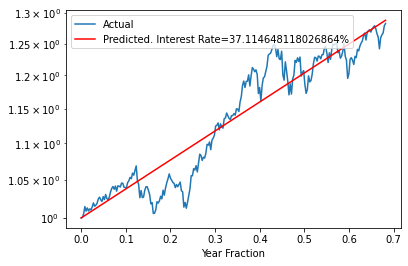

In [26]:
# Find a uniform market interest rate to normalize by. Consider a naive portfolio with equal weights.
normalized_prices = scaled_prices.sum(axis=1)
normalized_prices /= normalized_prices.iloc[0]
log_normalized_prices = np.log(normalized_prices)
lr = LinearRegression(fit_intercept=False)
num_days = len(log_normalized_prices)
X = (np.arange(0, num_days) / 365.25)[..., np.newaxis]
lr.fit(X, log_normalized_prices)
plt.semilogy(X, normalized_prices, label="Actual")
market_prices = np.exp(lr.predict(X))
interest_rate = lr.coef_[0]
plt.semilogy(X, market_prices, 'r', label=f"Predicted. Interest Rate={interest_rate * 100}%")
plt.legend(loc="best")
plt.xlabel("Year Fraction")
market_volatility = (normalized_prices / market_prices).std()
print(f"The market volatility is {market_volatility * 100}% at an interest rate of {interest_rate * 100}%.")

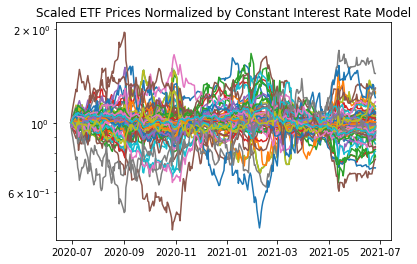

In [27]:
# Now, normalize each ETF by their ROR
normalized_prices = scaled_prices.copy()
prediction_period = np.array(NUM_DAYS_PREDICTION_PERIOD / 365).reshape((1,1))
mu = []
for etf_name in scaled_prices:
    etf_prices = scaled_prices[etf_name]
    lr.fit(X, np.log(etf_prices))
    model_prices = np.exp(lr.predict(X))
    normalized_prices[etf_name] /= model_prices
    last_day_price = etf_prices.iloc[-1]
    growth_rate = np.exp(lr.predict(prediction_period))
    mu.append(growth_rate) 

mu = np.array(mu)
_ = plt.semilogy(normalized_prices)
_ = plt.title("Scaled ETF Prices Normalized by Constant Interest Rate Model")

Text(0.5, 0, 'Expected Interest Rate')

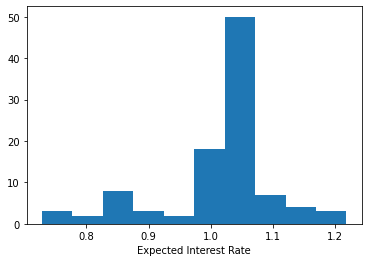

In [28]:
_ = plt.hist(mu)
plt.xlabel("Expected Interest Rate")

In [29]:
# Compute the covariancec
covariances = normalized_prices.cov()
sigma = np.array(covariances)
covariances

,XBI,VIXY,XLI,SVXY,SPXS,ERX,EWH,IEF,FXI,GLD,...,EWZ,LQD,MCHI,EEM,XME,FNGU,INDA,JDST,SDOW,IEMG
XBI,0.009921,0.004058,-0.000168,-0.001613,-0.001869,-0.001461,0.001567,0.000190,0.004637,-0.000759,...,0.002555,0.000621,0.004998,0.004092,0.001841,0.013153,0.002931,0.001519,-0.000684,0.003931
VIXY,0.004058,0.009812,-0.001325,-0.004464,0.002147,-0.005730,0.000228,0.000091,0.002496,-0.000441,...,-0.002016,-0.000108,0.003227,0.001529,-0.001064,0.007406,0.001164,0.001174,0.002939,0.001401
XLI,-0.000168,-0.001325,0.000917,0.000732,-0.001463,-0.001919,0.000110,0.000048,0.000389,0.000545,...,0.000235,0.000163,0.000469,0.000425,0.000720,0.002705,0.000586,-0.002272,-0.001688,0.000435
SVXY,-0.001613,-0.004464,0.000732,0.002120,-0.001284,0.001146,-0.000143,0.000020,-0.000874,0.000407,...,0.000970,0.000149,-0.001121,-0.000467,0.000475,-0.001830,-0.000321,-0.001316,-0.001509,-0.000413
SPXS,-0.001869,0.002147,-0.001463,-0.001284,0.004444,0.003543,-0.000790,-0.000193,-0.002350,-0.001328,...,-0.001725,-0.000568,-0.002718,-0.002221,-0.001669,-0.012331,-0.001963,0.005659,0.003873,-0.002206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FNGU,0.013153,0.007406,0.002705,-0.001830,-0.012331,-0.041679,0.001385,0.001745,0.014858,0.006832,...,0.001666,0.002797,0.019055,0.011755,0.000249,0.078092,0.011342,-0.028548,-0.006568,0.011481
INDA,0.002931,0.001164,0.000586,-0.000321,-0.001963,-0.005192,0.000405,0.000286,0.002641,0.001187,...,0.001166,0.000545,0.003240,0.002321,0.000921,0.011342,0.002533,-0.004894,-0.001312,0.002271
JDST,0.001519,0.001174,-0.002272,-0.001316,0.005659,0.028860,0.001829,-0.001494,-0.003538,-0.008213,...,-0.002847,-0.002060,-0.005957,-0.003286,-0.000008,-0.028548,-0.004894,0.031035,0.003240,-0.003308
SDOW,-0.000684,0.002939,-0.001688,-0.001509,0.003873,-0.000493,-0.000954,0.000061,-0.001174,-0.000640,...,-0.001155,-0.000187,-0.001170,-0.001345,-0.002253,-0.006568,-0.001312,0.003240,0.004412,-0.001353


In [30]:
def objective(portfolio_weights: np.ndarray, tradeoff_parameter: float) ->  float:
    return - expected_return(portfolio_weights) + tradeoff_parameter * weighted_covariance(portfolio_weights)

def expected_return(portfolio_weights: np.ndarray, mu: np.ndarray = mu) -> float:
    return portfolio_weights.transpose() @ mu

def weighted_covariance(portfolio_weights: np.ndarray, covariances: np.ndarray = sigma) -> float:
    return portfolio_weights.transpose() @ covariances @ portfolio_weights

num_symbols = len(mu)
x0 = np.ones((num_symbols, 1)) / num_symbols
constraints = [
    LinearConstraint(np.ones((1, num_symbols)), np.array([1.0]), np.array([1.0])),
    LinearConstraint(np.identity(num_symbols), np.zeros(num_symbols), np.ones(num_symbols)),
]
result = minimize(objective, x0, args=(100,), constraints=constraints)
result

     fun: array([-1.02572753])
     jac: array([-0.99297535, -0.95235769, -1.01129042, -1.01104876, -0.98403104,
       -0.94194815, -0.99668439, -0.99679899, -0.98789842, -0.98219511,
       -1.00948644, -1.01149665, -0.92787452, -0.99930923, -0.99505691,
       -0.99976766, -0.99530061, -1.00619724, -1.0017384 , -0.99830861,
       -1.0112166 , -1.0069177 , -0.99587898, -0.99738216, -1.0111728 ,
       -0.9912435 , -1.0032654 , -1.00036444, -1.01157971, -0.95267813,
       -0.97603796, -0.99792589, -1.00993118, -0.99932276, -1.00178561,
       -0.98389778, -1.00691345, -0.96030959, -1.00005768, -0.98402211,
       -0.99525405, -1.00006236, -0.99012379, -1.00257756, -0.99806947,
       -1.00039755, -1.00857794, -1.01127271, -1.01103857, -1.01167561,
       -1.00134157, -0.99318148, -0.99721929, -0.95431136, -0.97521254,
       -1.01135354, -1.01145644, -1.01044236, -1.00421642, -1.00404775,
       -1.0011396 , -0.94089387, -0.9896128 , -0.97434396, -1.00178856,
       -1.00058377, -1.

In [11]:
lbdas = np.logspace(-2, 3, 20)
xs = []
expected_returns = []
weighted_covariances = []
for i, lbda in enumerate(lbdas):
    result = minimize(objective, x0, args=(lbda,), constraints=constraints)
    xs.append(result.x)
    expected_returns.append(expected_return(result.x))
    weighted_covariances.append(weighted_covariance(result.x))
    print(f"Done with lambda {i+1} of {len(lbdas)}")

Done with lambda 1 of 20
Done with lambda 2 of 20
Done with lambda 3 of 20
Done with lambda 4 of 20
Done with lambda 5 of 20
Done with lambda 6 of 20
Done with lambda 7 of 20
Done with lambda 8 of 20
Done with lambda 9 of 20
Done with lambda 10 of 20
Done with lambda 11 of 20
Done with lambda 12 of 20
Done with lambda 13 of 20
Done with lambda 14 of 20
Done with lambda 15 of 20
Done with lambda 16 of 20
Done with lambda 17 of 20
Done with lambda 18 of 20
Done with lambda 19 of 20
Done with lambda 20 of 20


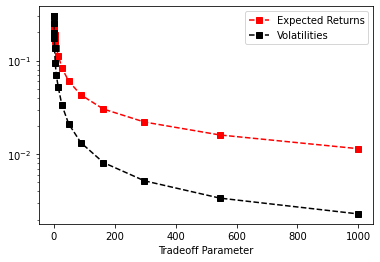

In [12]:
plt.semilogy(lbdas, np.array(expected_returns) - 1.0, 'rs--', label="Expected Returns")
plt.semilogy(lbdas, np.sqrt(weighted_covariances), 'ks--', label="Volatilities")
plt.legend(loc="best")
plt.xlabel("Tradeoff Parameter")
None

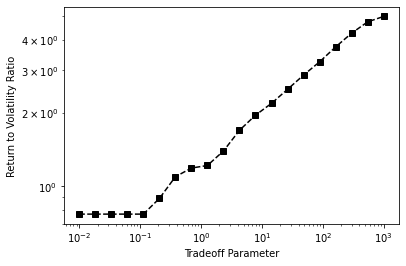

In [13]:
ratios = np.squeeze(np.array(expected_returns) - 1.0) / np.squeeze(np.sqrt(weighted_covariances))
plt.loglog(lbdas, ratios, 'ks--')
plt.xlabel("Tradeoff Parameter")
plt.ylabel("Return to Volatility Ratio")
None

Text(0, 0.5, 'Volatility relative to interest rate model')

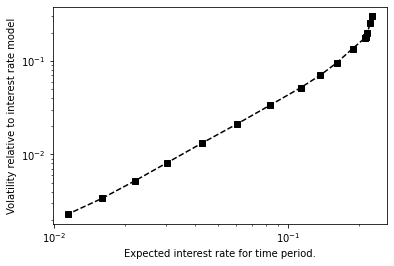

In [14]:
plt.loglog(np.array(expected_returns) - 1.0,  np.sqrt(weighted_covariances), 'ks--')
plt.xlabel("Expected interest rate for time period.")
plt.ylabel("Volatility relative to interest rate model")

In [15]:
symbols = scaled_prices.columns
selected_lbda = 100
selected_results = minimize(objective, x0, args=(selected_lbda,), constraints=constraints)
selected_x = selected_results.x
selected_series = pd.Series(selected_x, index=symbols)
selected_series

XBI     4.511745e-17
VIXY   -5.301216e-17
XLI     1.407202e-01
SVXY    8.894985e-02
SPXS   -3.001003e-17
            ...     
FNGU    8.675253e-17
INDA    4.518291e-02
JDST    5.473546e-03
SDOW   -4.020137e-17
IEMG   -3.791570e-18
Length: 100, dtype: float64

In [16]:
filtered_selected_series = selected_series.sort_values(ascending=False).iloc[:10]
filtered_selected_series = filtered_selected_series / filtered_selected_series.sum(axis=0)
filtered_selected_series

XLRE    0.202428
PDBC    0.194121
XLI     0.146969
TBT     0.107282
SVXY    0.092900
KRE     0.071573
ICLN    0.066766
TZA     0.053588
INDA    0.047189
XME     0.017184
dtype: float64

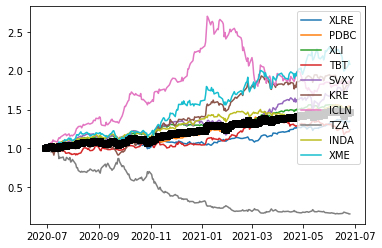

In [17]:
historic_performance = scaled_prices[filtered_selected_series.index]
aggregated_historic_performance = historic_performance.multiply(filtered_selected_series, axis=1).sum(axis=1)
for symbol in historic_performance:
    plt.plot(historic_performance[symbol], label=symbol)
plt.plot(aggregated_historic_performance, 'ks--')
plt.legend(loc="best")

In [18]:
etf_metadata = pd.read_csv(ETF_METADATA_FILEPATH)
etf_metadata = etf_metadata.set_index("Symbol")
etf_metadata["Weights"] = filtered_selected_series
etf_metadata = etf_metadata[~etf_metadata.Weights.isna()].sort_values("Weights", ascending=False)
etf_metadata

,Name,Avg Daily Share Volume (3mo),AUM,Weights
Symbol,,,,
XLRE,Real Estate Select Sector SPDR Fund,"4,800,819","$2,900,540.00",0.202428
PDBC,Invesco Optimum Yield Diversified Commodity St...,"3,698,367","$5,425,400.00",0.194121
XLI,Industrial Select Sector SPDR Fund,"12,974,922","$21,260,000.00",0.146969
TBT,UltraShort Barclays 20+ Year Treasury,"4,397,672","$1,358,440.00",0.107282
SVXY,ProShares Short VIX Short-Term Futures,"5,064,374","$544,812.00",0.092900
KRE,SPDR S&P Regional Banking ETF,"8,533,510","$5,609,480.00",0.071573
ICLN,iShares Global Clean Energy ETF,"7,803,403","$5,407,390.00",0.066766
TZA,Direxion Daily Small Cap Bear 3X Shares,"8,711,283","$374,560.00",0.053588
INDA,iShares MSCI India ETF,"4,389,039","$5,410,720.00",0.047189


In [19]:
yearly_interest_rate = np.squeeze(expected_return(selected_x) ** (365 / NUM_DAYS_PREDICTION_PERIOD) - 1.0) * 100
volatility = weighted_covariance(selected_x)**0.5 * 100
print(f"The expected interest rate over the time period is {yearly_interest_rate}%.")
print(f"The volatility over the time period is {volatility}%.")

The expected interest rate over the time period is 60.75365373853607%.
The volatility over the time period is 1.1920542363980502%.


In [20]:
etf_metadata.to_csv(OUTPUT_FILE)

The high interest rate and low volatility here is a bit suspicious. However, when one sees the 4-5x growth in the past year for some ETFs, it seems reasonable that this may be attainable. Overall, the current methodology seems somewhat more reasonable than that given in "etf_inspection.ipynb". The major difference are
- The model for growth in price is exponential rather than linear. This is more in line with traditional models.
- The S&P 500 is not used as a numeraire for the modeling. This was still somewhat volatile and likely hid some risk.
- The covariances are found for prices that are adjusted for thir rate of growth. It is thought that this explains more of the variance.
- The projections are made for a one month time-horizon.